## INFORMATION THEORY AND INFERENCE
#### Final Project
##### Missing and spurious interactions and the reconstruction of complex networks

## Group Members
#### Asal Rangrazi Asl



In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import math
import numpy as np
import random
import operator as op
from functools import reduce
from tqdm import tqdm
import copy
import seaborn as sn
import pickle
from scipy import io
import networkx as nx

### Loading dataset

In [2]:
import numpy as np

# Specify the file path
file_path = '/Users/asalrangraziasl/Documents/ Projects_Master/ Inference/FCth.txt'

# Load the data into a NumPy array
data = np.loadtxt(file_path)

# Now, 'data' contains your dataset as a NumPy array

In [3]:
data

array([[1.        , 0.29007275, 0.33406276, ..., 0.27619268, 0.38820639,
        0.24870905],
       [0.29007275, 1.        , 0.6728313 , ..., 0.20622525, 0.31493987,
        0.20340271],
       [0.33406276, 0.6728313 , 1.        , ..., 0.18990944, 0.34645661,
        0.17841752],
       ...,
       [0.27619268, 0.20622525, 0.18990944, ..., 1.        , 0.4226791 ,
        0.48421177],
       [0.38820639, 0.31493987, 0.34645661, ..., 0.4226791 , 1.        ,
        0.45591268],
       [0.24870905, 0.20340271, 0.17841752, ..., 0.48421177, 0.45591268,
        1.        ]])

Average connectivity strength: 0.30562303109507366
Maximum connectivity strength: 1.0
Minimum connectivity strength: -0.0011110186433460477


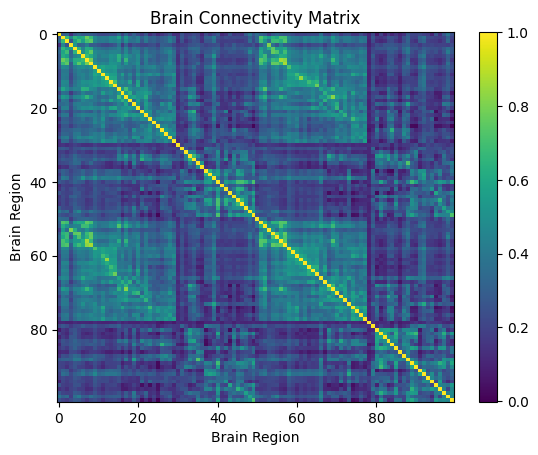

In [4]:
# Example: Calculate the average connectivity strength
average_strength = np.mean(data)
print("Average connectivity strength:", average_strength)

# Example: Calculate the maximum and minimum connectivity strengths
max_strength = np.max(data)
min_strength = np.min(data)
print("Maximum connectivity strength:", max_strength)
print("Minimum connectivity strength:", min_strength)

# Example: Visualize the connectivity matrix (optional)
import matplotlib.pyplot as plt

plt.imshow(data, cmap='viridis', origin='upper', aspect='auto')
plt.colorbar()
plt.title("Brain Connectivity Matrix")
plt.xlabel("Brain Region")
plt.ylabel("Brain Region")
plt.show()

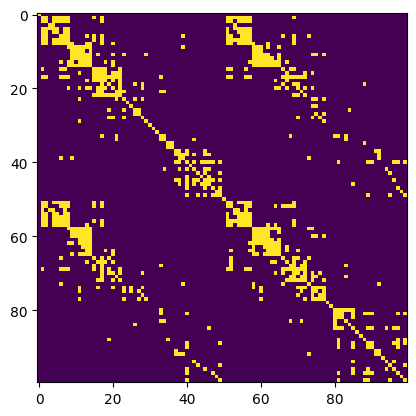

In [5]:
# Set a threshold value (adjust as needed)
threshold = 0.5

# Create a binary connectivity matrix by applying the threshold
A_T = (data > threshold).astype('float64')
A_T
np.save('AT',A_T)

plt.imshow(A_T)

In [6]:
type(A_T)
print(A_T.shape)
print(A_T.dtype)

(100, 100)
float64


In [7]:
#The purpose of this partitioning appears to be part of the Metropolis-Hastings algorithm.
# The binomial coefficien: C(n, r) = n! / (r! * (n - r)!)
def ncr(n, r):  #n choose r
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer // denom  # or / in Python 2

def index_2d(myList, v): #return the exact index
    for i, x in enumerate(myList):
        if v in x:
            return (i, x.index(v))

def l_ij(alpha,beta, A_T,part):       #number of links between group i and j
    link_num = 0
    for a in part[alpha]:
        for b in part[beta]:
            if A_T[a, b] == 1:
                link_num += 1
    return(link_num)


def r_ij(alpha,beta, part):       #maximum possible number of links between group i and j
    return(len(part[alpha]) * len(part[beta]))

In [8]:
def min_HP(A_T,all_part):
    minHP=np.nan
    for part in all_part:
        gooz_list = [[x,y] for x in range(len(part)) for y in range(len(part)) if len(part[x])<len(part[y])]
        pair_list=[]
        for x in gooz_list:
            if x not in pair_list: pair_list.append(x)

            # H(p) formula
        H_P = 0
        for pair in pair_list:
            alpha, beta = pair
            l = l_ij(alpha, beta, A_T, part)
            r = r_ij(alpha, beta, part)
            h_p = math.log(r+1) + math.log(ncr(r, l))
            H_P += h_p
        if np.isnan(minHP) or H_P <= minHP:
            minHP=H_P  
      
    return minHP

def R(i, j, A_T, all_part):   #all_part is a list containing all different partitions
    minHP=min_HP(A_T,all_part)
    Z=0
    big_sum= 0
    

    for part in all_part:
    
       
        gooz_list = [[x,y] for x in range(len(part)) for y in range(len(part)) if len(part[x])<len(part[y])]
        pair_list=[]
        for x in gooz_list:
            if x not in pair_list: pair_list.append(x)

            # H(p) formula
        H_P = 0
        for pair in pair_list:
            alpha, beta = pair
            l = l_ij(alpha, beta, A_T, part)
            r = r_ij(alpha, beta, part)
            h_p = math.log(r+1) + math.log(ncr(r, l))
            H_P += h_p
        Z += np.exp(minHP-H_P)
            # print('Pair:',pair,',l:',l,',r:',r,',h_p:',h_p,',H_P:',H_P)

            
        # define : (l(sigma_i,sigma_j) + 1) / (r(sigma_i,sigma_j) + 2) inside R formula
        sigma_i = index_2d(part, i)[0]
        sigma_j = index_2d(part, j)[0]
        l = l_ij(sigma_i , sigma_j , A_T, part)
        r = r_ij(sigma_i , sigma_j , part)
        parantez = ((l + 1)/(r+2))

        # print(Z)
        big_sum += np.exp(minHP+np.log(parantez)-H_P)
        
        
    R_ij = big_sum/Z
        # print('reliability of i={} and j={}:'.format(i, j), round(R_ij,4))
    return(round(R_ij,5))





In [9]:
# I also define H(P) seperatly because I need it in metropolis function
def H(P,AT_tmp):
    pair_list=[]
    H_P=0
    for i in range(len(P)):
        for j in range(len(P)):
            if i<=j:
                pair_list.append([i,j])
    for pair in pair_list:
            alpha, beta = pair
            l = l_ij(alpha, beta, AT_tmp, P)
            r = r_ij(alpha, beta, P)
            h_p = math.log(r+1) + math.log(ncr(r, l))
            H_P += h_p
    return(H_P)

In [10]:
def Metropolis(T,ens,AT_tmp):#number of iterations (ensemble size)
    e=[] #store result of simulation
    for i in tqdm(range(ens)):
        partitions =  [[i] for i in range(100)].copy()
        c=0
        for kk in range(T):
            partitions = [ele for ele in partitions if ele != []]
            part_before=copy.deepcopy(partitions)

            H0=H(partitions,AT_tmp) #compute hamiltonian
            rpp=random.randint(0,len(partitions)-1)
            m,n=index_2d(partitions,rpp)
            a=partitions[m][n] #select random partition from rpp
            del partitions[m][n] #delete an element at a specific position in a 2D list
            rp=random.randint(0,len(partitions)-1)
            partitions[rp].append(a) #moves (a) to another random partition rp
            Hf=H(partitions,AT_tmp)
            deltaH=Hf-H0 #calculates the change in energy due to move
            if deltaH>0:
                if random.random() > np.exp(-deltaH):
                    partitions=part_before.copy()
        ppp = [ele for ele in partitions if ele != []]
        e.append(ppp)
        #     partitions = [ele for ele in partitions if ele != []]
        #
        # ppp=copy.deepcopy(partitions)
        # e.append(ppp) # The final partitioning is appended to the e list
        print(H(partitions,AT_tmp))
        print(kk)
    return(e)

In [11]:
es = Metropolis(10000, 1,A_T)

100%|██████████| 1/1 [00:34<00:00, 34.37s/it]

1853.3387503620313
9999


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
(array([], dtype=int64), array([], dtype=int64))


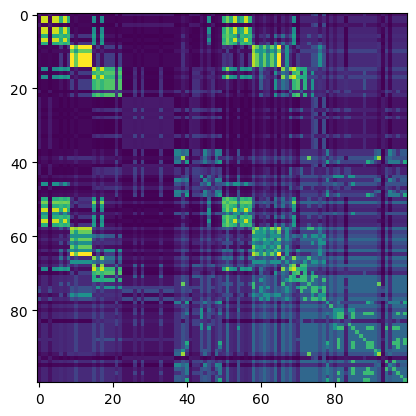

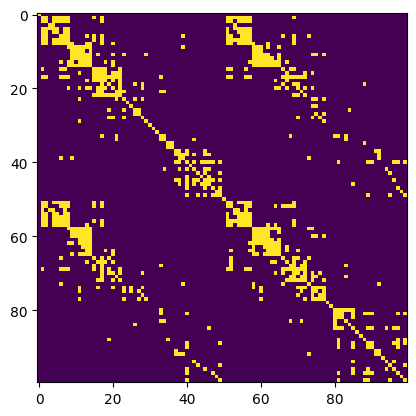

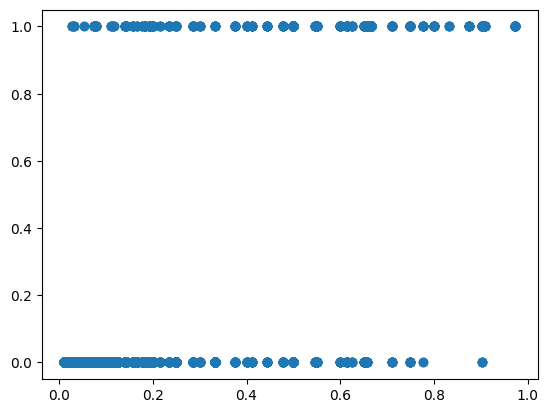

In [12]:
RR = np.zeros((100,100))

for i in range(100):
    print(i)
    for j in range(100):
        RR[i,j]=R(i, j, A_T, es)
        
plt.imshow(RR)


print(A_T)
print(np.where(np.isnan(A_T)))

plt.figure()

plt.imshow(A_T)

plt.figure()

plt.scatter(RR.reshape(-1),A_T.reshape(-1))

### Randomly remove links

In [13]:
def link_remover(A_T, ratio): #adjacency matrix :A_T #the ratio of links to be removed:ratio
    one_index = np.where(A_T==1)
    one_list = [[one_index[0][i], one_index[1][i]] for i in range(len(one_index[0]))]
    r = random.sample(one_list, int(ratio * np.sum(A_T)/2)) #randomly selects a subset of the pairs from
    return(r)

#sorting
def Sort(sub_li):
    sub_li.sort(key = lambda x: x[1])
    return sub_li.reverse()

#extract the first element
def Extract(lst):
    return list(list(zip(*lst))[0])

def acc(k):
    zeros=k.count(0)
    ones=k.count(1)
    ef=0
    for i in range(len(k)):
        if k[i]==1:
            ef+=k[i:].count(0)/zeros
    return ef/ones

We are computing the reliability of links that were originally set to zero in the adjacency matrix A_T. The code we've provided iterates through the zero entries in the adjacency matrix and calculates the reliability using the R function.

In [15]:
zero_real = []
zero_index = np.where(A_T==0)

for i in tqdm(range(len(zero_index[0]))):
    #computed reliability for each link is appended to the zero_real list
    zero_real.append(R(zero_index[0][i], zero_index[1][i], A_T, es))

100%|██████████| 9165/9165 [00:54<00:00, 169.08it/s]


In [16]:
rat=np.linspace(0.1,1,10)#removal ratio
accs=[]
for r in rat:
    A_T = np.load('AT.npy')
    selected_links = link_remover(A_T, r)#select links to remove from the adjacency matrix (based on ratio)
    #Set the selected links to 0 in the adjacency matrix to simulate link removal.
    #print(selected_links)
    for link in selected_links: A_T[link[0], link[1]] = 0
    #Calculate the reliability of the removed links using the R function and store these values in the zero_fake lis
    zero_fake=[]
    for i in selected_links:
        zero_fake.append(R(i[0], i[1], A_T, es))
    #Print the mean value of the reliabilities of the removed links
    print('the mean value', round(np.mean(zero_fake),2))
    #aggregate all the reliabilities (both real and removed)
    all_real = []
    for i in zero_fake: all_real.append([1, i])
    for i in zero_real: all_real.append([0, i])
    Sort(all_real)
    ext=Extract(all_real)
    accs.append(acc(ext))

the mean value 0.4
the mean value 0.38
the mean value 0.38
the mean value 0.36
the mean value 0.35
the mean value 0.33
the mean value 0.33
the mean value 0.3
the mean value 0.28
the mean value 0.28


Text(0.5, 1.0, 'Missing intractions')

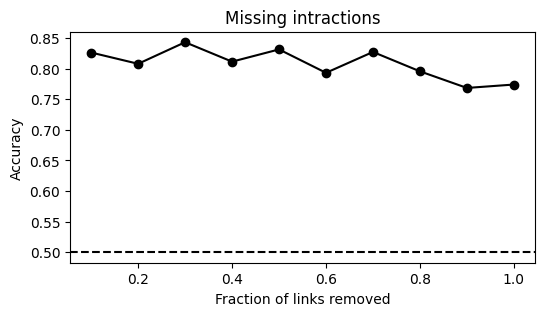

In [17]:
plt.figure(figsize=(6,3))
plt.plot(rat,accs,'-o',color='black')
plt.axhline(y = 0.5, color = 'k', linestyle = '--')
plt.ylabel('Accuracy')
plt.xlabel('Fraction of links removed')
plt.title('Missing intractions')


### Spurious Intercations (Adding Links)

In [18]:
#add links to the adjacency matrix A_T based on a specified ratio
def link_adder(A_T, ratio):
    zero_index = np.where(A_T==0)
    zero_list = [[zero_index[0][i], zero_index[1][i]] for i in range(len(zero_index[0]))]
    r = random.sample(zero_list, int(ratio * np.sum(A_T)/2))
    return(r)

#sorting
def Sort(sub_li):
    sub_li.sort(key = lambda x: x[1])
    return sub_li.reverse()

#extract the first element
#This function is intended to extract the first elements from a list of pairs
def Extract(lst):
    return list(list(zip(*lst))[0])

In [19]:
def acc(k):
    zeros = k.count(0)
    ones = k.count(1)

    if zeros == 0:
        return 0  # Handle the case when there are no zeros (or return another appropriate value)

    ef = 0
    for i in range(len(k)):
        if k[i] == 1:
            ef += k[i:].count(0) / zeros

    return ef / ones

In [20]:
one_real = []
one_index = np.where(A_T==1)#find the indices of one entries in the adjacency matrix

for i in tqdm(range(len(one_index[0]))):#find the indices of one entries in the adjacency matrix
    #computed reliability for each link is appended to the one_real list
    one_real.append(R(one_index[0][i], one_index[1][i], A_T, es))

100%|██████████| 439/439 [00:02<00:00, 166.34it/s]


In [21]:
rat=np.linspace(0.1,1,10)
accs=[]
for r in rat:
    A_T = np.load('AT.npy')
    selected_links = link_adder(A_T, r)
    for link in selected_links: A_T[link[0], link[1]] = 1
    np.save('A0',A_T)
    one_fake=[]
    for i in selected_links:
        one_fake.append(R(i[0], i[1], A_T, es))
    print('the mean value', round(np.mean(one_fake),2))
    all_real = []
    for i in one_fake: all_real.append([0, i])
    for i in one_real: all_real.append([1, i])
    Sort(all_real)
    ext=Extract(all_real)
    accs.append(acc(ext))

the mean value 0.22
the mean value 0.21
the mean value 0.23
the mean value 0.24
the mean value 0.25
the mean value 0.27
the mean value 0.26
the mean value 0.27
the mean value 0.27
the mean value 0.26


Text(0.5, 1.0, 'ُSpurious intractions')

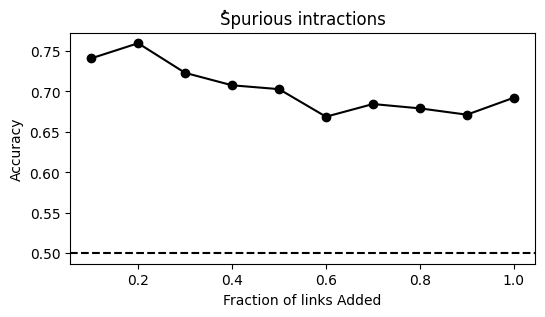

In [22]:
plt.figure(figsize=(6,3))
plt.plot(rat,accs,'-o',color='black')
plt.axhline(y = 0.5, color = 'k', linestyle = '--')
plt.ylabel('Accuracy')
plt.xlabel('Fraction of links Added')
plt.title('ُSpurious intractions')

### Load True Network and observed Network

In [23]:
A_O = np.load('A0.npy')
A_T = np.load('AT.npy')

In [24]:
num_zeros_A_T = (A_T == 0).sum()
print('number of zero in true network',num_zeros_A_T)
num_one_A_T = (A_T == 1).sum()
print('number of one in true network',num_one_A_T)

number of zero in true network 9122
number of one in true network 878


In [25]:
num_zeros_A_O = (A_O == 0).sum()
print('number of zero in A_O network',num_zeros_A_O)
num_one_A_O = (A_O == 1).sum()
print('number of one in A_O network',num_one_A_O)

number of zero in A_O network 8683
number of one in A_O network 1317


In [26]:
# create empty matrix of shape A_O
shape_o=np.shape(A_O)
R_matix=np.zeros(shape_o)
es = Metropolis(100, 20,A_O)

  5%|▌         | 1/20 [00:00<00:17,  1.08it/s]

2799.46961186436
99


 10%|█         | 2/20 [00:01<00:14,  1.23it/s]

2810.8324156461736
99


 15%|█▌        | 3/20 [00:02<00:12,  1.31it/s]

2772.903159781169
99


 20%|██        | 4/20 [00:03<00:12,  1.33it/s]

2774.3645831813647
99


 25%|██▌       | 5/20 [00:03<00:11,  1.30it/s]

2770.2045019758607
99


 30%|███       | 6/20 [00:04<00:10,  1.32it/s]

2830.0923835447143
99


 35%|███▌      | 7/20 [00:05<00:10,  1.30it/s]

2823.7928810059893
99


 40%|████      | 8/20 [00:06<00:09,  1.29it/s]

2846.005465672264
99


 45%|████▌     | 9/20 [00:07<00:08,  1.28it/s]

2822.2333815696547
99


 50%|█████     | 10/20 [00:07<00:07,  1.28it/s]

2789.339764904494
99


 55%|█████▌    | 11/20 [00:08<00:07,  1.24it/s]

2847.2617456422936
99


 60%|██████    | 12/20 [00:09<00:06,  1.23it/s]

2867.4062161649963
99


 65%|██████▌   | 13/20 [00:10<00:05,  1.25it/s]

2828.7117211585564
99


 70%|███████   | 14/20 [00:11<00:04,  1.27it/s]

2841.971908589398
99


 75%|███████▌  | 15/20 [00:11<00:03,  1.30it/s]

2788.203934141969
99


 80%|████████  | 16/20 [00:12<00:03,  1.31it/s]

2807.9139568532064
99


 85%|████████▌ | 17/20 [00:13<00:02,  1.32it/s]

2827.4701604539787
99


 90%|█████████ | 18/20 [00:14<00:01,  1.30it/s]

2848.0578232980483
99


 95%|█████████▌| 19/20 [00:14<00:00,  1.32it/s]

2844.9779189986793
99


100%|██████████| 20/20 [00:15<00:00,  1.29it/s]

2800.3119951348626
99


### Calculating the reliability matrix for Observed network & true network

In [ ]:
for i in range(shape_o[0]):
    for j in range(shape_o[1]):
        R_matix[i][j]= R(i,j, A_O, es)

np.save('R_matix',R_matix)

In [27]:
R_matix=np.load('/Users/asalrangraziasl/Documents/ Projects_Master/ Inference/R_matix.npy')
print(np.max(R_matix))
print(np.min(R_matix))
R_matix

0.83333
0.05882


array([[0.54545, 0.125  , 0.125  , ..., 0.125  , 0.2    , 0.125  ],
       [0.125  , 0.5    , 0.33333, ..., 0.16667, 0.25   , 0.33333],
       [0.25   , 0.33333, 0.66667, ..., 0.16667, 0.25   , 0.33333],
       ...,
       [0.25   , 0.16667, 0.16667, ..., 0.5    , 0.25   , 0.16667],
       [0.2    , 0.25   , 0.25   , ..., 0.25   , 0.66667, 0.25   ],
       [0.125  , 0.33333, 0.33333, ..., 0.16667, 0.25   , 0.66667]])

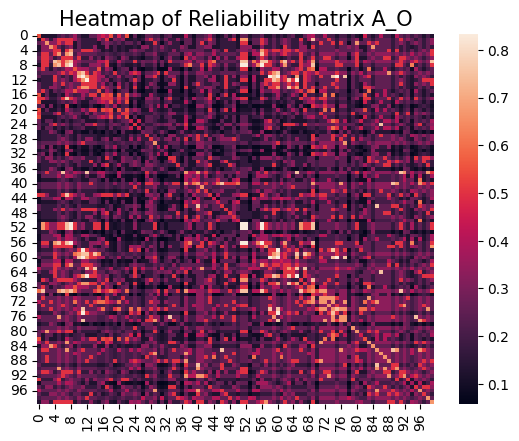

In [28]:
hm = sn.heatmap(data = R_matix)
#the plotted heatmap
plt.title('Heatmap of Reliability matrix A_O', fontsize = 15)
plt.show()

In [29]:
A_O[np.where(R_matix > 0.5)] = 1
A_O[np.where(R_matix < 0.5)] = 0

Text(0.5, 1.0, 'Reliability matrix for A_O')

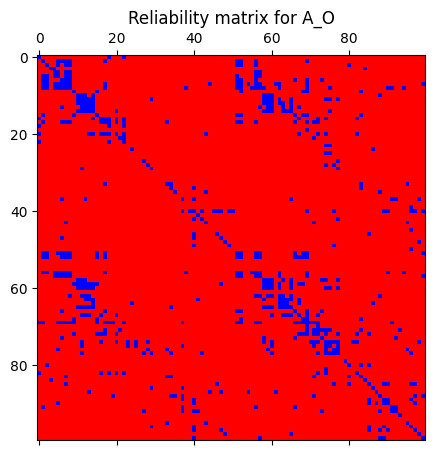

In [30]:
from matplotlib.colors import ListedColormap
fig, (ax1) = plt.subplots(ncols=1, figsize=(5, 5))
cmap = ListedColormap(['r', 'b'])
ax1.matshow(A_O, interpolation=None, aspect='auto',cmap=cmap)
ax1.set_title('Reliability matrix for A_O')

In [31]:
shape_T=np.shape(A_T)
R_mat_A_T=np.zeros(shape_T)
es = Metropolis(100, 20,A_O)

  5%|▌         | 1/20 [00:00<00:18,  1.05it/s]

2501.8116602659643
99


 10%|█         | 2/20 [00:01<00:15,  1.19it/s]

2493.7595374556317
99


 15%|█▌        | 3/20 [00:02<00:13,  1.23it/s]

2432.7479387576514
99


 20%|██        | 4/20 [00:03<00:12,  1.30it/s]

2271.5505798085546
99


 25%|██▌       | 5/20 [00:03<00:11,  1.30it/s]

2395.4922976584294
99


 30%|███       | 6/20 [00:04<00:10,  1.31it/s]

2430.6420013581596
99


 35%|███▌      | 7/20 [00:05<00:09,  1.36it/s]

2435.1237654365073
99


 40%|████      | 8/20 [00:06<00:08,  1.38it/s]

2302.1576865396064
99


 45%|████▌     | 9/20 [00:06<00:08,  1.30it/s]

2374.490472318643
99


 50%|█████     | 10/20 [00:07<00:07,  1.30it/s]

2387.416537696502
99


 55%|█████▌    | 11/20 [00:08<00:07,  1.28it/s]

2439.84552742278
99


 60%|██████    | 12/20 [00:09<00:06,  1.31it/s]

2363.057388727946
99


 65%|██████▌   | 13/20 [00:09<00:05,  1.33it/s]

2392.2006648835245
99


 70%|███████   | 14/20 [00:10<00:04,  1.29it/s]

2392.6763656149133
99


 75%|███████▌  | 15/20 [00:11<00:04,  1.25it/s]

2421.18193459245
99


 80%|████████  | 16/20 [00:12<00:03,  1.28it/s]

2421.8949895106866
99


 85%|████████▌ | 17/20 [00:13<00:02,  1.31it/s]

2254.264963271637
99


 90%|█████████ | 18/20 [00:13<00:01,  1.32it/s]

2508.415212049107
99


 95%|█████████▌| 19/20 [00:14<00:00,  1.30it/s]

2430.152277812967
99


100%|██████████| 20/20 [00:15<00:00,  1.30it/s]

2445.5776458688033
99


In [ ]:
for i in range(shape_T[0]):
    for j in range(shape_T[1]):
        R_mat_A_T[i][j]= R(i,j, A_T, es)

np.save('R_mat_A_T',R_mat_A_T)

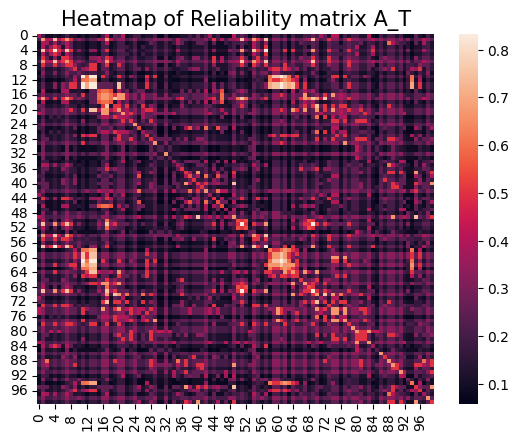

In [33]:
R_mat_A_T=np.load('/Users/asalrangraziasl/Documents/ Projects_Master/ Inference/R_mat_A_T.npy')
hm = sn.heatmap(data = R_mat_A_T)
plt.title('Heatmap of Reliability matrix A_T', fontsize = 15)
#the plotted heatmap
plt.show()

In [34]:
print(np.max(R_mat_A_T))
print(np.min(R_mat_A_T))
R_mat_A_T

0.83297
0.05882


array([[0.36364, 0.19991, 0.09091, ..., 0.09095, 0.2    , 0.12509],
       [0.19991, 0.66646, 0.39981, ..., 0.39971, 0.33323, 0.25   ],
       [0.09091, 0.39981, 0.36364, ..., 0.36334, 0.2    , 0.12509],
       ...,
       [0.09095, 0.39971, 0.36334, ..., 0.36381, 0.20006, 0.12516],
       [0.2    , 0.33323, 0.2    , ..., 0.20006, 0.66667, 0.2501 ],
       [0.12509, 0.25   , 0.12509, ..., 0.12516, 0.2501 , 0.50021]])

In [35]:
A_T[np.where(R_mat_A_T > 0.5)] = 1
A_T[np.where(R_mat_A_T < 0.5)] = 0

Text(0.5, 1.0, 'Reliability matrix for A_T')

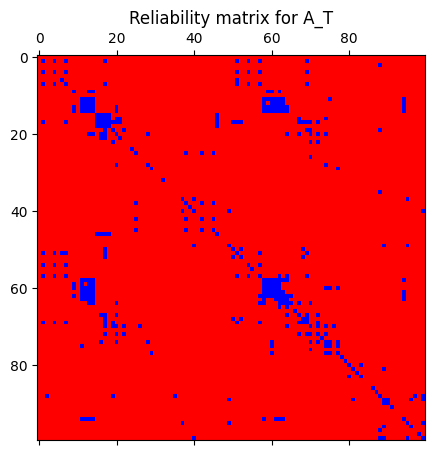

In [36]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(5, 5))
cmap = ListedColormap(['r', 'b'])
ax1.matshow(A_T, interpolation=None, aspect='auto',cmap=cmap)
ax1.set_title('Reliability matrix for A_T')

Text(0.5, 1.0, 'Difference of A_O and A_T')

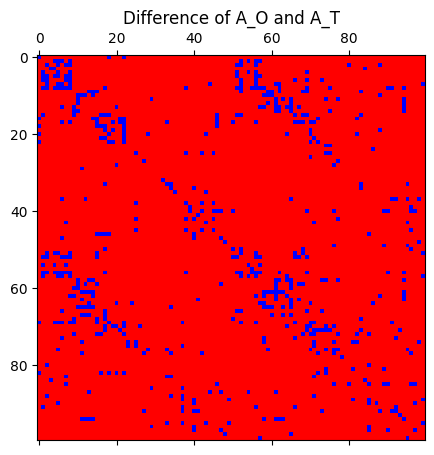

In [37]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(5, 5))
cmap = ListedColormap(['r', 'b'])
ax1.matshow(abs(A_O - A_T), interpolation=None, aspect='auto', cmap=cmap)
ax1.set_title('Difference of A_O and A_T')